# 1. Loading Data

- We have already saved data into two csv files, `Fundamental_features.csv` and `Tech_Features.csv`. <br>
- Here, we just load and record them as `data_f` and `data_t`.

In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
try:
    from sklearn.impute import SimpleImputer # Scikit-Learn 0.20+
except ImportError:
    from sklearn.preprocessing import Imputer as SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import skew, mstats
from scipy.stats import kurtosis

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
data_f = pd.read_csv(r"Fundamental_features.csv",index_col=0)
#f for Fundamental
data_t = pd.read_csv(r"Tech_Features.csv",index_col = 0)
# t for Tech

Get SP500 index from yahoo finance for feature engineering purpose.

In [3]:
from yahoofinancials import YahooFinancials

In [4]:
yahoo_financials = YahooFinancials("^GSPC")
historical_stock_prices = yahoo_financials.get_historical_price_data('2018-06-01', '2019-06-01', 'daily')

In [5]:
sp500 = pd.DataFrame(historical_stock_prices["^GSPC"]["prices"])
sp500.head()

,adjclose,close,date,formatted_date,high,low,open,volume
0,2734.620117,2734.620117,1527859800,2018-06-01,2736.929932,2718.699951,2718.699951,3684130000
1,2746.870117,2746.870117,1528119000,2018-06-04,2749.159912,2740.540039,2741.669922,3376510000
2,2748.800049,2748.800049,1528205400,2018-06-05,2752.610107,2739.510010,2748.459961,3517790000
3,2772.350098,2772.350098,1528291800,2018-06-06,2772.389893,2748.459961,2753.250000,3651640000
4,2770.370117,2770.370117,1528378200,2018-06-07,2779.899902,2760.159912,2774.840088,3711330000


# 2. Imputing missing values and Standardization

For both technical and fundamental features, there are some missing values.
1. For Technical features, there might be some stocks that contain missing values. We will drop those stocks with unmatching dates.
2. Since the number of stocks might be different in `data_f` and `data_t`, we use inner join to combine them and get `feature_df`
3. Then, we fillin the missing values and standardize the combined results and get `train_df`

### 2.1. Technical features

**2.1.1 Drop missing values**

In [6]:
data_t.head()

,ticker,date,close_price,open_price,high,low,volume
0,A,2018/6/1,62.215069,62.470001,63.230000,62.439999,2277900
1,A,2018/6/4,62.809677,63.169998,63.509998,62.759998,1958000
2,A,2018/6/5,62.948418,63.459999,63.869999,63.090000,1889500
3,A,2018/6/6,64.603386,63.750000,65.190002,63.060001,3177600
4,A,2018/6/7,64.643036,65.410004,66.089996,64.800003,2977200


In [7]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126309 entries, 0 to 126308
Data columns (total 7 columns):
ticker         126309 non-null object
date           126309 non-null object
close_price    126309 non-null float64
open_price     126309 non-null float64
high           126309 non-null float64
low            126309 non-null float64
volume         126309 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 7.7+ MB


Drop the missing values

In [8]:
#find ticker short of dates
ticker_delete = []
tickers = data_t["ticker"].unique()
rst = data_t.groupby('ticker')['date'].count()
for ticker in tickers:
    if rst[ticker] != int(rst.median()):
        ticker_delete.append(ticker)

print("Stock with unmatching data:")
print(ticker_delete)
for ticker in ticker_delete:
    data_t =data_t.drop(data_t[data_t["ticker"]== ticker ].index, axis = 0)
#display(len(ticker_delete))

Stock with unmatching data:
['CTVA', 'DOW', 'ZTS']


In [9]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125500 entries, 0 to 125555
Data columns (total 7 columns):
ticker         125500 non-null object
date           125500 non-null object
close_price    125500 non-null float64
open_price     125500 non-null float64
high           125500 non-null float64
low            125500 non-null float64
volume         125500 non-null int64
dtypes: float64(4), int64(1), object(2)
memory usage: 7.7+ MB


In [10]:
data_t.head()

,ticker,date,close_price,open_price,high,low,volume
0,A,2018/6/1,62.215069,62.470001,63.230000,62.439999,2277900
1,A,2018/6/4,62.809677,63.169998,63.509998,62.759998,1958000
2,A,2018/6/5,62.948418,63.459999,63.869999,63.090000,1889500
3,A,2018/6/6,64.603386,63.750000,65.190002,63.060001,3177600
4,A,2018/6/7,64.643036,65.410004,66.089996,64.800003,2977200


**2.1.2 Feature engineering**

In [11]:
# get close price, volume and return dataframes

close_df = data_t.pivot(index='ticker', columns='date',values='close_price')
volume_df = data_t.pivot(index='ticker', columns='date',values='volume')
return_df = (close_df.pct_change(axis='columns')).drop(close_df.columns[0], axis=1)

In [12]:
display(close_df.head())
display(volume_df.head())
display(return_df.head())

date,2018/10/1,2018/10/10,2018/10/11,2018/10/12,2018/10/15,2018/10/16,2018/10/17,2018/10/18,2018/10/19,2018/10/2,...,2019/5/24,2019/5/28,2019/5/29,2019/5/3,2019/5/30,2019/5/31,2019/5/6,2019/5/7,2019/5/8,2019/5/9
ticker,,,,,,,,,,,,,,,,,,,,,
A,70.939178,66.369835,64.597847,65.941765,65.334518,67.156281,66.897453,65.453979,64.179749,71.357285,...,68.360001,67.080002,67.300003,79.290001,66.889999,67.050003,79.349998,76.669998,76.610001,77.000000
AAL,39.280209,31.346817,31.009647,30.652645,31.515402,33.002914,33.290501,31.793072,31.773239,38.179455,...,29.170000,28.730000,28.410000,34.689884,28.170000,27.230000,34.649998,33.910000,33.750000,33.950001
AAP,169.472855,163.047669,160.919266,164.996201,166.804840,168.243774,159.460373,162.068420,164.206802,168.273743,...,158.089996,154.559998,155.779999,163.270004,159.389999,155.000000,161.990005,160.660004,158.619995,159.889999
AAPL,224.637604,213.863373,211.975418,219.547028,214.851822,219.586548,218.637650,213.527298,216.779327,226.634293,...,178.970001,178.229996,177.380005,210.937683,178.300003,175.070007,207.680222,202.081787,202.121628,199.949997
ABBV,91.640549,89.788445,87.492599,88.418823,86.946632,89.608261,89.959244,87.648605,85.766937,90.897774,...,80.059998,78.029999,78.059998,78.709999,77.610001,76.709999,79.260002,77.949997,77.989998,77.910004


date,2018/10/1,2018/10/10,2018/10/11,2018/10/12,2018/10/15,2018/10/16,2018/10/17,2018/10/18,2018/10/19,2018/10/2,...,2019/5/24,2019/5/28,2019/5/29,2019/5/3,2019/5/30,2019/5/31,2019/5/6,2019/5/7,2019/5/8,2019/5/9
ticker,,,,,,,,,,,,,,,,,,,,,
A,2837500,3055700,3624200,3669500,1602800,1868300,1991200,2327300,2418300,2617500,...,3852900,2984700,3722100,1303200,2947900,2829300,1624300,1732200,2243600,1717500
AAL,7210700,20539000,17115800,12905200,11092500,11339200,15068600,12778300,10445200,7625000,...,5764000,8362800,6248100,5181400,4734100,7441400,4156800,6957800,4374100,4500100
AAP,591600,997300,1345400,1096700,644900,1067700,1967500,1393600,1406100,819300,...,2127800,1207500,1665200,760200,1080200,1487200,1218600,1069400,586200,883600
AAPL,23600800,41990600,53124400,40337900,30791000,29184000,22885400,32581300,33078700,24788200,...,23714700,27948200,28481200,20892400,21218400,27043600,32443100,38763700,26339500,34908600
ABBV,3763800,5310800,9994400,5709600,4827900,3787100,2857400,4422300,7059400,6792200,...,3872700,6557800,4182200,4527300,3533100,4003200,5413200,4275300,3820700,3792200


date,2018/10/10,2018/10/11,2018/10/12,2018/10/15,2018/10/16,2018/10/17,2018/10/18,2018/10/19,2018/10/2,2018/10/22,...,2019/5/24,2019/5/28,2019/5/29,2019/5/3,2019/5/30,2019/5/31,2019/5/6,2019/5/7,2019/5/8,2019/5/9
ticker,,,,,,,,,,,,,,,,,,,,,
A,-0.064412,-0.026699,0.020804,-0.009209,0.027884,-0.003854,-0.021577,-0.019468,0.111835,-0.103237,...,0.009749,-0.018724,0.003280,0.178157,-0.156388,0.002392,0.183445,-0.033774,-0.000783,0.005091
AAL,-0.201969,-0.010756,-0.011513,0.028146,0.047200,0.008714,-0.044981,-0.000624,0.201623,-0.164675,...,-0.011186,-0.015084,-0.011138,0.221045,-0.187948,-0.033369,0.272494,-0.021356,-0.004718,0.005926
AAP,-0.037913,-0.013054,0.025335,0.010962,0.008626,-0.052206,0.016355,0.013194,0.024767,-0.021556,...,-0.010701,-0.022329,0.007893,0.048081,-0.023764,-0.027543,0.045097,-0.008210,-0.012698,0.008007
AAPL,-0.047963,-0.008828,0.035719,-0.021386,0.022037,-0.004321,-0.023374,0.015230,0.045461,-0.037640,...,-0.003841,-0.004135,-0.004769,0.189185,-0.154727,-0.018116,0.186270,-0.026957,0.000197,-0.010744
ABBV,-0.020211,-0.025569,0.010586,-0.016650,0.030612,0.003917,-0.025685,-0.021468,0.059823,-0.096132,...,-0.013432,-0.025356,0.000384,0.008327,-0.013975,-0.011596,0.033242,-0.016528,0.000513,-0.001026


In [13]:
return_sp = ((sp500.adjclose.diff()/sp500.adjclose)[1:]).mean()
return_sp

-2.0488704098321853e-05

In [14]:
return_std = return_df.std(axis=1)
return_skew = return_df.skew(axis=1)
return_kurtosis = return_df.kurtosis(axis=1)
Max_Drawdown = (1 - close_df/close_df.cummax(axis = 1)).max(axis=1)
sharpe_ratio = (return_df.mean(axis=1)-return_sp)/return_std
volume_std = volume_df.std(axis=1)

In [15]:
t_feature = pd.DataFrame()
t_feature = t_feature.assign(Return_std = return_std, Return_skew =return_skew, Return_kurtosis = return_kurtosis, Sharpe_Ratio = sharpe_ratio, Volume_std = volume_std, Maxdrawdown = Max_Drawdown)
t_feature

,Return_std,Return_skew,Return_kurtosis,Sharpe_Ratio,Volume_std,Maxdrawdown
ticker,,,,,,
A,0.043125,0.572325,6.139398,0.029342,1.295404e+06,0.184895
AAL,0.059415,1.234017,8.127841,0.019145,3.349883e+06,0.386307
AAP,0.037719,-0.349844,9.141565,0.013477,5.052240e+05,0.305764
AAPL,0.048445,-0.566217,9.829872,0.015749,1.402302e+07,0.385159
ABBV,0.034534,0.708604,9.355761,-0.001167,2.907568e+06,0.206139
ABC,0.036612,0.493178,8.751954,0.002376,6.654572e+05,0.241906
ABMD,0.061791,1.046393,7.520872,-0.003845,3.929518e+05,0.440823
ABT,0.025669,-0.330823,3.736180,0.020432,2.033788e+06,0.192504
ACN,0.033928,0.844985,9.996897,0.019971,9.226801e+05,0.225383


### 2.2 Fandamental features

**2.2.1 Check null value in fundamental features**

In [16]:
data_f.head()

,Ticker,annualHoldingsTurnover,enterpriseToRevenue,beta3Year,profitMargins,enterpriseToEbitda,52WeekChange,morningStarRiskRating,forwardEps,revenueQuarterlyGrowth,...,lastCapGain,shortPercentOfFloat,sharesShortPriorMonth,category,fiveYearAverageReturn,eps,Market Cap,PE,NI,EBIT
0,A,NaN,4.306,NaN,0.22255,17.757,0.051262617,NaN,3.40,NaN,...,NaN,0.0146,3687978.0,NaN,NaN,3.443000,2.221115e+10,20.415335,3.160000e+08,9.740000e+08
1,AAL,NaN,0.958,NaN,0.03215,7.364,-0.2998188,NaN,5.76,NaN,...,NaN,0.0561,23003563.0,NaN,NaN,3.118000,1.368313e+10,9.865298,1.412000e+09,3.757000e+09
2,AAP,NaN,1.428,NaN,0.04448,14.394,0.17042124,NaN,9.49,NaN,...,NaN,0.0471,2882176.0,NaN,NaN,5.856000,1.095011e+10,26.215847,4.238470e+08,7.121420e+08
3,AAPL,NaN,3.511,NaN,0.22117,11.732,-0.005647659,NaN,12.78,NaN,...,NaN,0.0105,61003851.0,NaN,NaN,11.887001,8.860000e+11,16.200891,5.953100e+10,7.089800e+10
4,ABBV,NaN,4.507,NaN,0.16418,10.552,-0.22391498,NaN,9.42,NaN,...,NaN,0.0163,27575807.0,NaN,NaN,3.511000,1.140000e+11,21.916832,5.687000e+09,1.191100e+10


In [17]:
# drop empty columns
data_f = data_f.dropna(axis='columns', how='all')
data_f = data_f[:-2]

# drop date columns and useless columns
data_f = data_f.drop(['fundInceptionDate','sharesShortPreviousMonthDate', 'lastSplitDate', 'lastSplitFactor','priceHint', 'dateShortInterest', 'maxAge'], axis=1)

In [18]:
data_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 33 columns):
Ticker                     501 non-null object
enterpriseToRevenue        498 non-null float64
profitMargins              500 non-null float64
enterpriseToEbitda         466 non-null float64
52WeekChange               500 non-null object
forwardEps                 498 non-null float64
sharesOutstanding          500 non-null float64
bookValue                  498 non-null float64
sharesShort                499 non-null float64
sharesPercentSharesOut     499 non-null float64
lastFiscalYearEnd          500 non-null float64
heldPercentInstitutions    499 non-null float64
netIncomeToCommon          500 non-null float64
trailingEps                498 non-null float64
SandP52WeekChange          500 non-null float64
priceToBook                473 non-null float64
heldPercentInsiders        499 non-null float64
nextFiscalYearEnd          500 non-null float64
mostRecentQuarter          500 no

**2.2.2 Combine Features**

First, copy data into data_f_train and reset the index

In [19]:
#copy into data_f
f_feature = data_f.copy()

In [20]:
#reset the index
f_feature.index = data_f["Ticker"]
f_feature = f_feature.drop(["Ticker"],axis = 1)

In [21]:
# in case there are infinity entries
f_feature = f_feature.replace([np.inf, -np.inf,"infinity","Infinity"], np.nan)

In [22]:
f_feature.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, A to ZTS
Data columns (total 32 columns):
enterpriseToRevenue        498 non-null float64
profitMargins              500 non-null float64
enterpriseToEbitda         466 non-null float64
52WeekChange               498 non-null object
forwardEps                 498 non-null float64
sharesOutstanding          500 non-null float64
bookValue                  498 non-null float64
sharesShort                499 non-null float64
sharesPercentSharesOut     499 non-null float64
lastFiscalYearEnd          500 non-null float64
heldPercentInstitutions    499 non-null float64
netIncomeToCommon          500 non-null float64
trailingEps                498 non-null float64
SandP52WeekChange          500 non-null float64
priceToBook                473 non-null float64
heldPercentInsiders        499 non-null float64
nextFiscalYearEnd          500 non-null float64
mostRecentQuarter          500 non-null float64
shortRatio                 499 non-nu

In [23]:
f_feature.head()

,enterpriseToRevenue,profitMargins,enterpriseToEbitda,52WeekChange,forwardEps,sharesOutstanding,bookValue,sharesShort,sharesPercentSharesOut,lastFiscalYearEnd,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
Ticker,,,,,,,,,,,,,,,,,,,,,
A,4.306,0.22255,17.757,0.051262617,3.40,3.159930e+08,16.153,4636334.0,0.0146,1.540944e+09,...,-0.112,2.30,20.673529,0.0146,3687978.0,3.443000,2.221115e+10,20.415335,3.160000e+08,9.740000e+08
AAL,0.958,0.03215,7.364,-0.2998188,5.76,4.448350e+08,-1.432,20867364.0,0.0469,1.546214e+09,...,0.164,0.41,5.340278,0.0561,23003563.0,3.118000,1.368313e+10,9.865298,1.412000e+09,3.757000e+09
AAP,1.428,0.04448,14.394,0.17042124,9.49,7.132690e+07,49.732,2867611.0,0.0400,1.546042e+09,...,0.042,1.09,16.177029,0.0471,2882176.0,5.856000,1.095011e+10,26.215847,4.238470e+08,7.121420e+08
AAPL,3.511,0.22117,11.732,-0.005647659,12.78,4.601080e+09,22.977,49550348.0,0.0108,1.538179e+09,...,-0.164,1.37,15.068858,0.0105,61003851.0,11.887001,8.860000e+11,16.200891,5.953100e+10,7.089800e+10
ABBV,4.507,0.16418,10.552,-0.22391498,9.42,1.478330e+09,-5.294,21309313.0,0.0144,1.546214e+09,...,-0.117,1.16,8.168790,0.0163,27575807.0,3.511000,1.140000e+11,21.916832,5.687000e+09,1.191100e+10


In [24]:
# show the difference between two dataframe
t_inx = t_feature.index
f_inx = f_feature.index
display(t_inx.difference(f_inx))
display(f_inx.difference(t_inx))

Index(['FLR', 'MAT'], dtype='object')

Index(['CTVA', 'DOW', 'ZTS'], dtype='object')

In [25]:
feature_df = t_feature.join(f_feature, how='inner')
feature_df.head()

,Return_std,Return_skew,Return_kurtosis,Sharpe_Ratio,Volume_std,Maxdrawdown,enterpriseToRevenue,profitMargins,enterpriseToEbitda,52WeekChange,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
A,0.043125,0.572325,6.139398,0.029342,1.295404e+06,0.184895,4.306,0.22255,17.757,0.051262617,...,-0.112,2.30,20.673529,0.0146,3687978.0,3.443000,2.221115e+10,20.415335,3.160000e+08,9.740000e+08
AAL,0.059415,1.234017,8.127841,0.019145,3.349883e+06,0.386307,0.958,0.03215,7.364,-0.2998188,...,0.164,0.41,5.340278,0.0561,23003563.0,3.118000,1.368313e+10,9.865298,1.412000e+09,3.757000e+09
AAP,0.037719,-0.349844,9.141565,0.013477,5.052240e+05,0.305764,1.428,0.04448,14.394,0.17042124,...,0.042,1.09,16.177029,0.0471,2882176.0,5.856000,1.095011e+10,26.215847,4.238470e+08,7.121420e+08
AAPL,0.048445,-0.566217,9.829872,0.015749,1.402302e+07,0.385159,3.511,0.22117,11.732,-0.005647659,...,-0.164,1.37,15.068858,0.0105,61003851.0,11.887001,8.860000e+11,16.200891,5.953100e+10,7.089800e+10
ABBV,0.034534,0.708604,9.355761,-0.001167,2.907568e+06,0.206139,4.507,0.16418,10.552,-0.22391498,...,-0.117,1.16,8.168790,0.0163,27575807.0,3.511000,1.140000e+11,21.916832,5.687000e+09,1.191100e+10


**2.2.3 Using Pipeline to impute missing data and standardize data**

**Building pipeline to transform data**

In [26]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):                            
        return X[self.attribute_names].values

features = feature_df.columns

Preprocess_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector( features )), #set the parameter for DataDrameSelector
        ("imputer", SimpleImputer(strategy="mean")), 
        ("StandardScaler", StandardScaler(copy=True, with_mean=True, with_std=True))
               
    ])

In [27]:
train_array = Preprocess_pipeline.fit_transform(feature_df)

In [28]:
train_df = pd.DataFrame(train_array)
train_df.index = feature_df.index
train_df.columns = feature_df.columns
train_df.head()

,Return_std,Return_skew,Return_kurtosis,Sharpe_Ratio,Volume_std,Maxdrawdown,enterpriseToRevenue,profitMargins,enterpriseToEbitda,52WeekChange,...,earningsQuarterlyGrowth,pegRatio,forwardPE,shortPercentOfFloat,sharesShortPriorMonth,eps,Market Cap,PE,NI,EBIT
A,0.094856,0.006040,-0.605859,0.475872,-0.242593,-0.884750,-0.003771,0.585808,0.157156,0.122861,...,-0.279218,-0.055273,0.107010,-0.566081,-0.522212,-0.329256,-0.286444,-0.116362,-0.408348,-0.377613
AAL,1.125625,0.616008,-0.336546,-0.216733,0.255217,1.098249,-0.857910,-0.795718,-0.701360,-1.295051,...,-0.020532,-0.096079,-0.969212,0.404423,0.698724,-0.378467,-0.370058,-0.162484,-0.192662,0.121120
AAP,-0.247229,-0.844045,-0.199249,-0.601689,-0.434058,0.305263,-0.738004,-0.706253,-0.120645,0.604107,...,-0.134879,-0.081398,-0.208594,0.193952,-0.573147,0.036115,-0.396855,-0.091004,-0.387124,-0.424540
AAPL,0.431492,-1.043505,-0.106025,-0.447365,2.841372,1.086948,-0.206591,0.575795,-0.340540,-0.106982,...,-0.327957,-0.075352,-0.286375,-0.661962,3.100718,0.949315,8.182730,-0.134787,11.244807,12.153264
ABBV,-0.448719,0.131666,-0.170238,-1.596339,0.148042,-0.675596,0.047508,0.162280,-0.438014,-0.988499,...,-0.283905,-0.079886,-0.770682,-0.526325,0.987735,-0.318959,0.613516,-0.109798,0.648633,1.582375


**After the transformation above, we can see from the tables above that there is no null value and data is standardized (mean =0, std = 1)**

# 3. PCA

**However, there is one more step needed to be done bofore feeding data into clustering model:** <br>
There are strong correlations between the features, `Pricipal Components Anlysis (PCA)` can be used here to reduce dimensions and reduce correlations.

In [29]:
def heatMap(df, mirror):

    # Create Correlation df
    corr = df.corr()
    # Plot figsize
    fig, ax = plt.subplots(figsize=(20, 20))
    # Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
   
    if mirror == True:
        #Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
        #Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns);
        #Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns)
        #show plot
    else:
        # Drop self-correlations
        dropSelf = np.zeros_like(corr)
        dropSelf[np.triu_indices_from(dropSelf)] = True
        # Generate Color Map
        colormap = sns.diverging_palette(220, 10, as_cmap=True)
        # Generate Heat Map, allow annotations and place floats in map
        sns.heatmap(corr, cmap=colormap, annot=True, fmt=".1f", mask=dropSelf)
        # Apply xticks
        plt.xticks(range(len(corr.columns)), corr.columns);
        # Apply yticks
        plt.yticks(range(len(corr.columns)), corr.columns)
    # show plot
    plt.show()

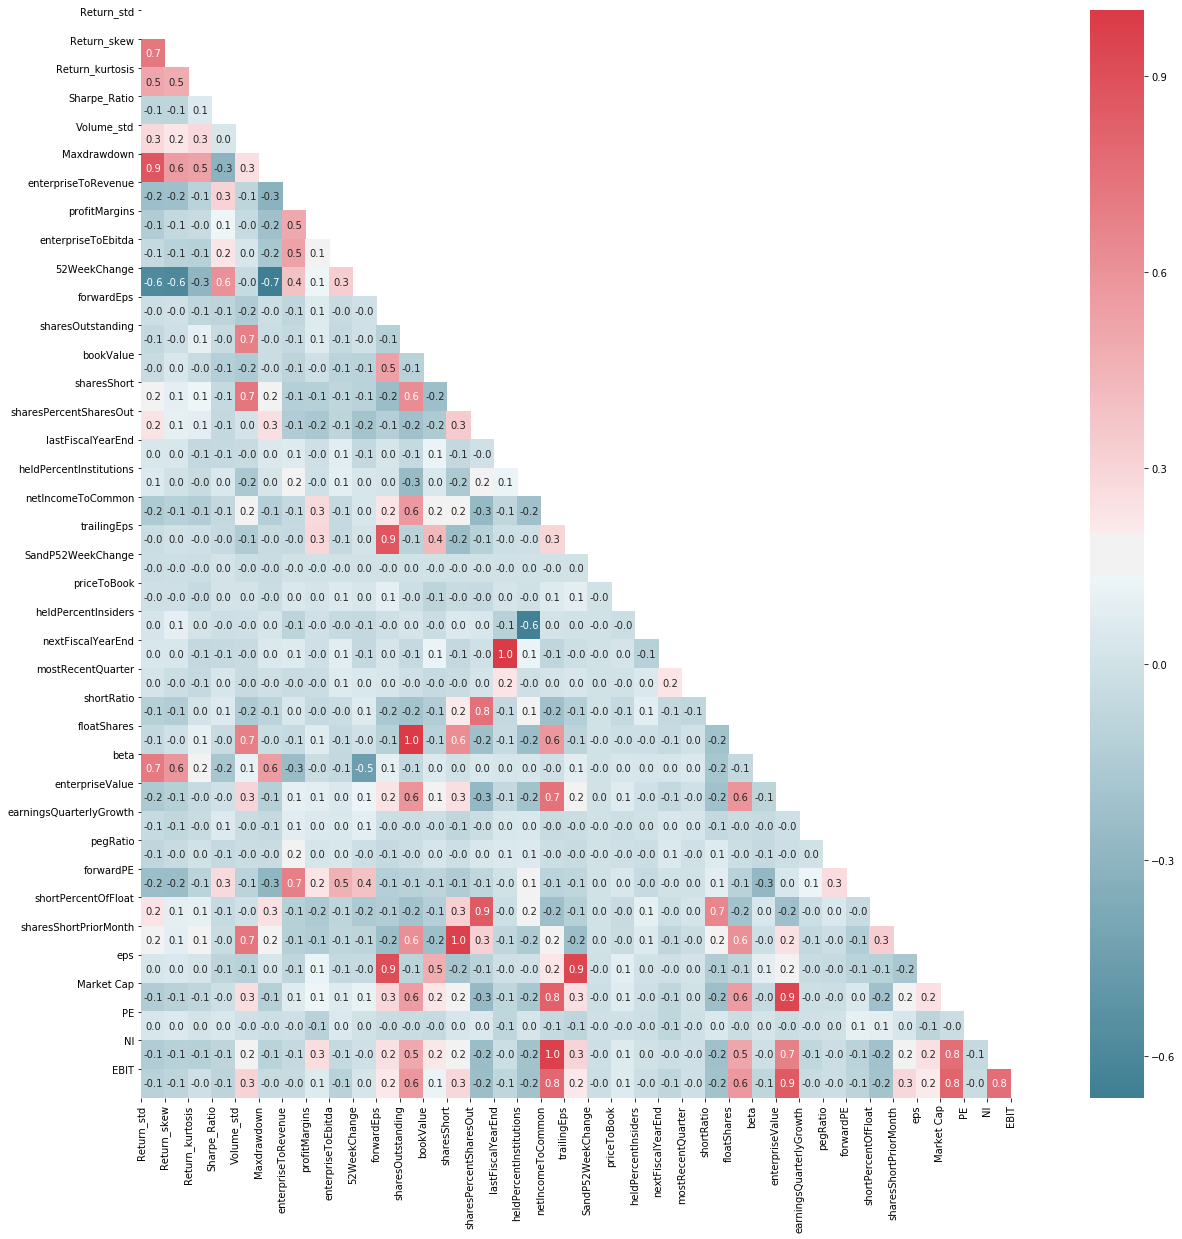

In [30]:
heatMap(train_df,False)

In [31]:
pca_feature = PCA(random_state=100)
_ = pca_feature.fit(train_df)

In [32]:
acc_va_ratio = np.cumsum(pca_feature.explained_variance_ratio_)
acc_va_ratio

array([0.17231691, 0.30987144, 0.42117517, 0.48784798, 0.54725828,
       0.60251051, 0.64375901, 0.68201865, 0.71392365, 0.74409713,
       0.7724872 , 0.7992044 , 0.82415852, 0.84862874, 0.87194803,
       0.89170754, 0.90717656, 0.92025792, 0.93265523, 0.94256944,
       0.95203073, 0.96022914, 0.96720658, 0.97368832, 0.97929205,
       0.98382195, 0.98763889, 0.99069897, 0.993321  , 0.99565956,
       0.99708538, 0.99805994, 0.99879023, 0.99943534, 0.99982482,
       0.99994705, 1.        , 1.        ])

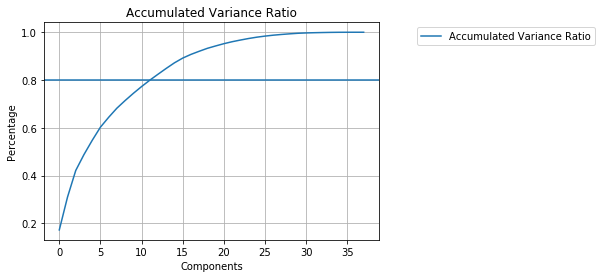

In [33]:
PCA_var_ratio=plt.figure()
plt.plot(acc_va_ratio)
plt.legend(["Accumulated Variance Ratio"],bbox_to_anchor=(1.1,1))
plt.grid()
plt.title("Accumulated Variance Ratio")
plt.xlabel('Components')
plt.ylabel('Percentage')
plt.axhline(y=0.8)
_ = plt.show()

As we set the threshold to 0.8, we keep the first 13 components

In [34]:
m_pca = PCA(n_components=13).fit_transform(train_df)

# Agglometative Clustering

In [35]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
import pylab

In [36]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabaz_score, silhouette_score


def AC_optimal_clusters(df, n, link, dis):
    num_of_cluster = np.arange(2,n+2,1)
    real_cluster = []
    ch_score = []
    sh_score = []
    for i in range(n):
        AC_model = AgglomerativeClustering(n_clusters=i+2, linkage = link, affinity=dis)
        predicted = AC_model.fit_predict(df)
        real_cluster.append(len(set(predicted) ))
        ch_score.append(calinski_harabaz_score(X = df,labels = predicted ))
        sh_score.append(silhouette_score(X = df, labels = predicted))
        
    print(num_of_cluster)
    AC_clusters=plt.figure()
    plt.plot(num_of_cluster,ch_score)
    plt.plot(num_of_cluster,sh_score)
    plt.plot(num_of_cluster, real_cluster)
    plt.grid()
    plt.legend(["ch_score", "sh_score","real_cluster_num"],bbox_to_anchor=(1.1,1))
    plt.title("CH_score with different number of clusters")
    plt.xlabel('Number of Clusters')
    _ = plt.show()
    
    print("Optimal number for clusters:")
    print(num_of_cluster[np.argmax(ch_score)])
    print("Largest CH_score:")
    print(max(ch_score))

def AC_grid_search(df,n,link_list,aff_list,cluster_thre, ch_thre):
    for i in link_list:
        for j in aff_list:
            print(i, j,':')
            try:
                num_of_cluster = np.arange(2,n+2,1)
                real_cluster = []
                ch_score = []
                sh_score = []
                for k in range(n):
                    AC_model = AgglomerativeClustering(n_clusters=k+2, linkage = i, affinity=j)
                    predicted = AC_model.fit_predict(df)
                    real_cluster.append(len(set(predicted) ))
                    ch_score.append(calinski_harabaz_score(X = df,labels = predicted ))
                    sh_score.append(silhouette_score(X = df, labels = predicted))
                    
                if (num_of_cluster[np.argmax(ch_score)]>=cluster_thre) and (max(ch_score)>=ch_thre):
                    print('above threshold')
                    SC_clusters=plt.figure()
                    plt.plot(num_of_cluster,ch_score)
                    plt.plot(num_of_cluster,sh_score)
                    plt.plot(num_of_cluster, real_cluster)
                    plt.grid()
                    plt.legend(["ch_score", "sh_score","real_cluster_num"],bbox_to_anchor=(1.1,1))
                    plt.title("CH_score with different number of clusters")
                    plt.xlabel('Number of Clusters')
                    _ = plt.show()
                    
                    print("Optimal number for clusters:",num_of_cluster[np.argmax(ch_score)])
                    print("Largest CH_score:", max(ch_score))
                    print(' ')
                    
                else:
                    print('below threshold')
                    print(' ')
        
            except:
                print('not applicable')
                print(' ')


In [37]:
affinity_list = ['euclidean','l1','l2','manhattan','cosine','precomputed']
linkage_list = ['ward','complete', 'average', 'single']

## 1.1 without PCA

ward euclidean :
below threshold
 
ward l1 :
not applicable
 
ward l2 :
not applicable
 
ward manhattan :
not applicable
 
ward cosine :
not applicable
 
ward precomputed :
not applicable
 
complete euclidean :
above threshold


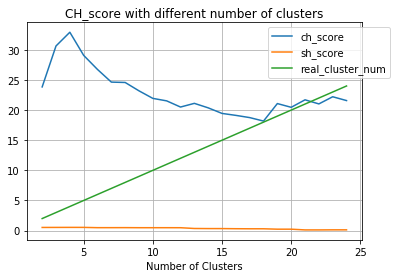

Optimal number for clusters: 4
Largest CH_score: 32.917828686971475
 
complete l1 :
below threshold
 
complete l2 :
above threshold


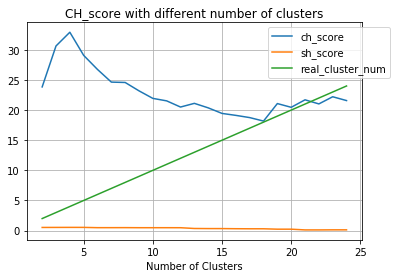

Optimal number for clusters: 4
Largest CH_score: 32.917828686971475
 
complete manhattan :
below threshold
 
complete cosine :
below threshold
 
complete precomputed :
not applicable
 
average euclidean :
below threshold
 
average l1 :
above threshold


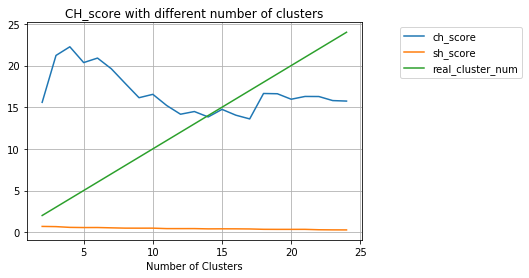

Optimal number for clusters: 4
Largest CH_score: 22.254273044412173
 
average l2 :
below threshold
 
average manhattan :
above threshold


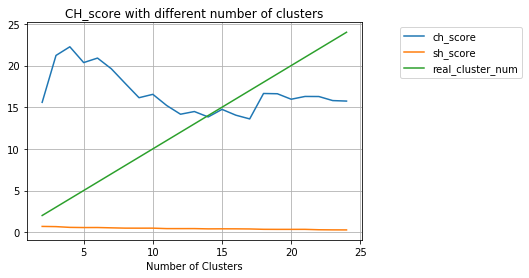

Optimal number for clusters: 4
Largest CH_score: 22.254273044412173
 
average cosine :
below threshold
 
average precomputed :
not applicable
 
single euclidean :
below threshold
 
single l1 :
below threshold
 
single l2 :
below threshold
 
single manhattan :
below threshold
 
single cosine :
below threshold
 
single precomputed :
not applicable
 


In [38]:
AC_grid_search(train_df,23,linkage_list,affinity_list, 4,20)

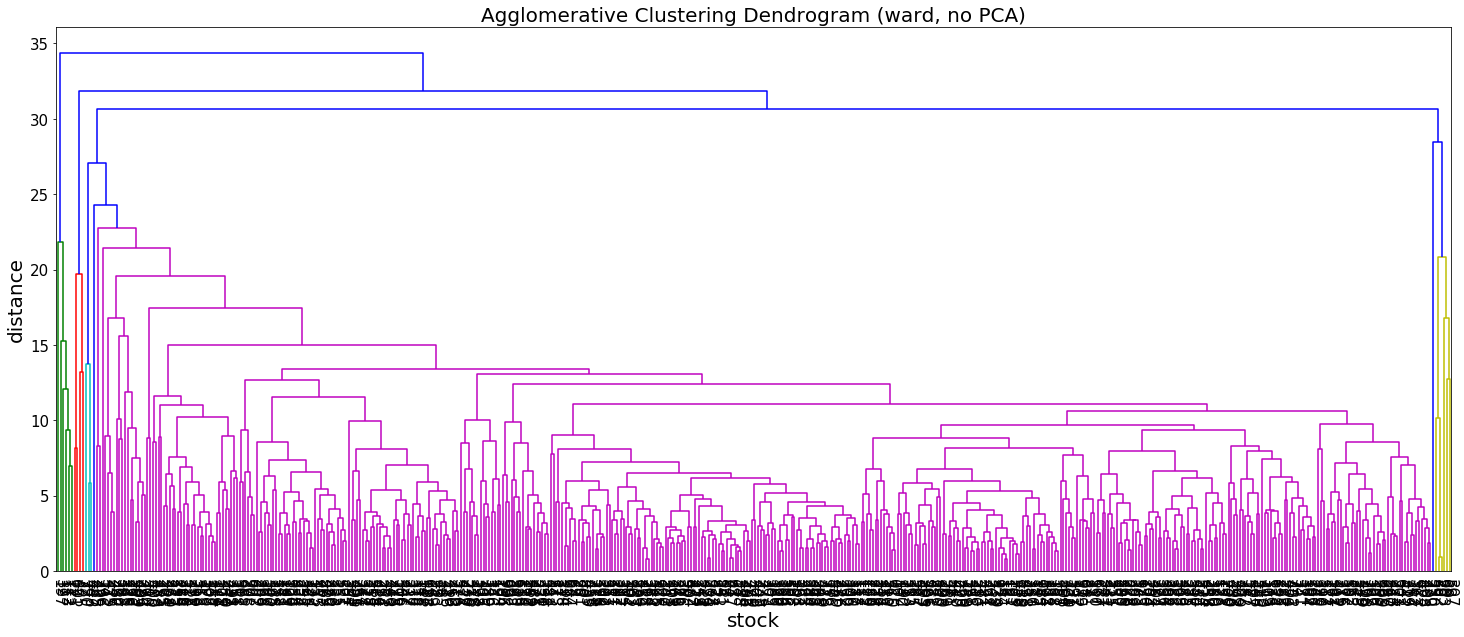

In [39]:
ward_nopca = linkage(train_df, 'complete')
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Agglomerative Clustering Dendrogram (ward, no PCA)', fontsize=labelsize)
plt.xlabel('stock', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    ward_nopca,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.show()

## 1.2 With PCA

ward euclidean :
below threshold
 
ward l1 :
not applicable
 
ward l2 :
not applicable
 
ward manhattan :
not applicable
 
ward cosine :
not applicable
 
ward precomputed :
not applicable
 
complete euclidean :
below threshold
 
complete l1 :
above threshold


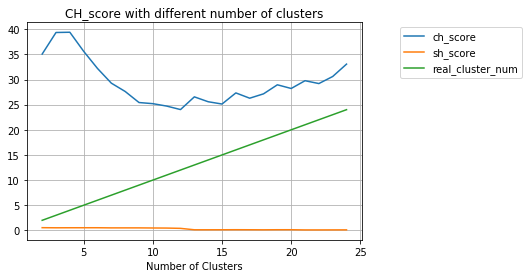

Optimal number for clusters: 4
Largest CH_score: 39.39895615779287
 
complete l2 :
below threshold
 
complete manhattan :
above threshold


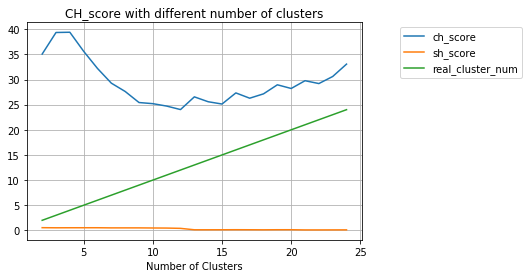

Optimal number for clusters: 4
Largest CH_score: 39.39895615779287
 
complete cosine :
above threshold


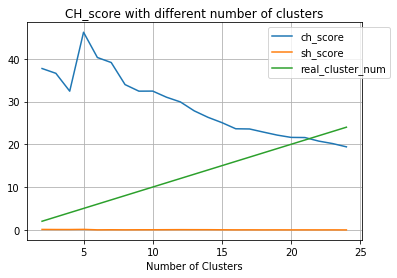

Optimal number for clusters: 5
Largest CH_score: 46.213449740133555
 
complete precomputed :
not applicable
 
average euclidean :
above threshold


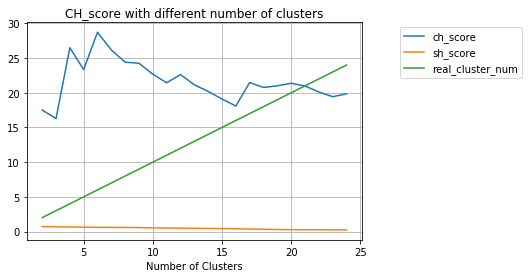

Optimal number for clusters: 6
Largest CH_score: 28.722722710390123
 
average l1 :
below threshold
 
average l2 :
above threshold


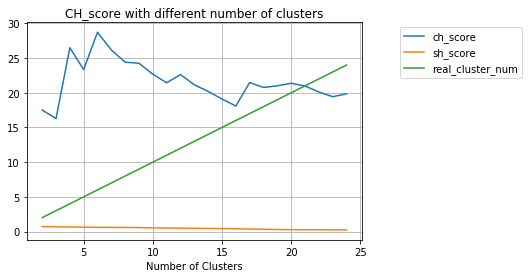

Optimal number for clusters: 6
Largest CH_score: 28.722722710390123
 
average manhattan :
below threshold
 
average cosine :
below threshold
 
average precomputed :
not applicable
 
single euclidean :
below threshold
 
single l1 :
below threshold
 
single l2 :
below threshold
 
single manhattan :
below threshold
 
single cosine :
below threshold
 
single precomputed :
not applicable
 


In [40]:
AC_grid_search(m_pca,23,linkage_list,affinity_list,4,25)

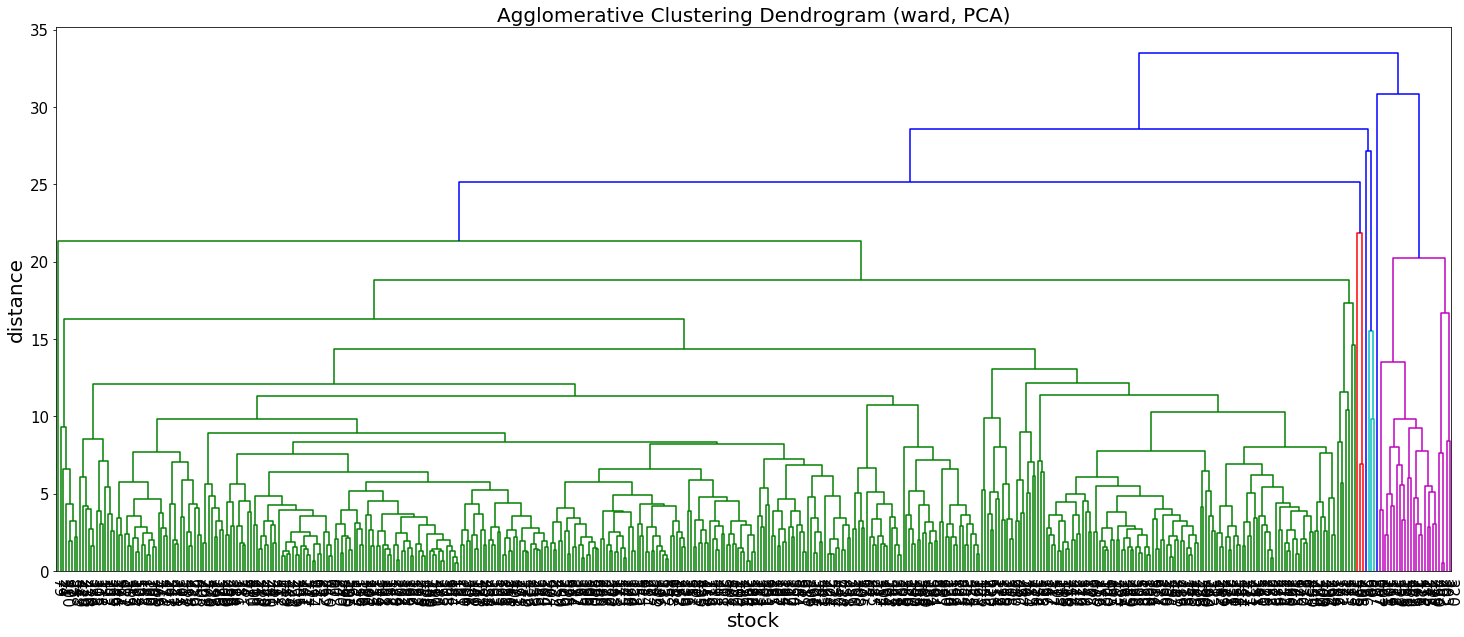

In [41]:
ward_pca = linkage(m_pca, 'complete')
plt.figure(figsize=(25, 10))
labelsize=20
ticksize=15
plt.title('Agglomerative Clustering Dendrogram (ward, PCA)', fontsize=labelsize)
plt.xlabel('stock', fontsize=labelsize)
plt.ylabel('distance', fontsize=labelsize)
dendrogram(
    ward_pca,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
pylab.yticks(fontsize=ticksize)
pylab.xticks(rotation=-90, fontsize=ticksize)
plt.show()

# Spectral Clustering

In [42]:
from sklearn.cluster import SpectralClustering

def SC_optimal_clusters(df, n, init, gam, dis, neighb):
    num_of_cluster = np.arange(2,n+2,1)
    real_cluster = []
    ch_score = []
    sh_score = []
    for i in range(n):
        SC_model = SpectralClustering(n_clusters=i+2, n_init= init, gamma= gam, affinity=dis, n_neighbors=neighb)
        predicted = SC_model.fit_predict(m_pca)
        real_cluster.append(len(set(predicted) ))
        ch_score.append(calinski_harabaz_score(X = df,labels = predicted ))
        sh_score.append(silhouette_score(X = df, labels = predicted))
        
    print(num_of_cluster)
    SC_clusters=plt.figure()
    plt.plot(num_of_cluster,ch_score)
    plt.plot(num_of_cluster,sh_score)
    plt.plot(num_of_cluster, real_cluster)
    plt.grid()
    plt.legend(["ch_score", "sh_score","real_cluster_num"],bbox_to_anchor=(1.1,1))
    plt.title("CH_score with different number of clusters")
    plt.xlabel('Number of Clusters')
    _ = plt.show()
    
    print("Optimal number for clusters:")
    print(num_of_cluster[np.argmax(ch_score)])
    print("Largest CH_score:")
    print(max(ch_score))
    
def SC_grid_search(df,n,ninit,gamma,aff_list,neighbors,cluster_thre,ch_thre):
    for i in ninit:
        for j in gamma:
            for l in aff_list:
                for m in neighbors:
                    #print('n_init=',i,'gamma =',"%.2f" % j,'affinity = ',l, 'n_neighbors = ',m, ':')
                    try:
                            num_of_cluster = np.arange(2,n+2,1)
                            real_cluster = []
                            ch_score = []
                            sh_score = []
                            for k in range(n):
                                SC_model = SpectralClustering(n_clusters=k+2, n_init= i, gamma= j, affinity=l, n_neighbors=m)
                                predicted = SC_model.fit_predict(df)
                                real_cluster.append(len(set(predicted) ))
                                ch_score.append(calinski_harabaz_score(X = df,labels = predicted ))
                                sh_score.append(silhouette_score(X = df, labels = predicted))
                                
                            if (num_of_cluster[np.argmax(ch_score)]>=cluster_thre) and (max(ch_score)>=ch_thre):
                                print('n_init=',i,'gamma =',"%.2f" % j,'affinity = ',l, 'n_neighbors = ',m, ':')
                                print('above threshold')
                                SC_clusters=plt.figure()
                                plt.plot(num_of_cluster,ch_score)
                                plt.plot(num_of_cluster,sh_score)
                                plt.plot(num_of_cluster, real_cluster)
                                plt.grid()
                                plt.legend(["ch_score", "sh_score","real_cluster_num"],bbox_to_anchor=(1.1,1))
                                plt.title("CH_score with different number of clusters")
                                plt.xlabel('Number of Clusters')
                                _ = plt.show()
                                    
                                print("Optimal number for clusters:",num_of_cluster[np.argmax(ch_score)])
                                print("Largest CH_score:", max(ch_score))
                                print(' ')
                                
                            #else:
                                #print('below threshold')
                                #print(' ')
                    except:
                        #print('not applicable')
                        #print(' ')
                        pass

In [44]:
init_list = np.arange(5,30,5)
gamma_list = np.arange(0.5,2.0,0.5)
aff_list = ['nearest_neighbors','precomputed','rbf']
neighbor_list = np.arange(5,30,5)

n_init= 5 gamma = 0.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


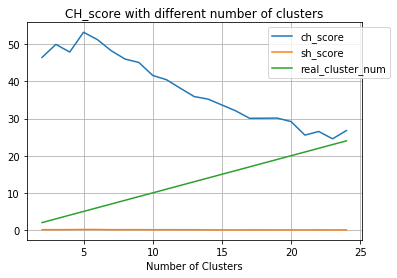

Optimal number for clusters: 5
Largest CH_score: 53.23855647337132
 
n_init= 5 gamma = 1.00 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


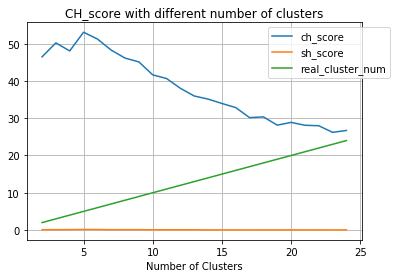

Optimal number for clusters: 5
Largest CH_score: 53.06531407499532
 
n_init= 5 gamma = 1.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


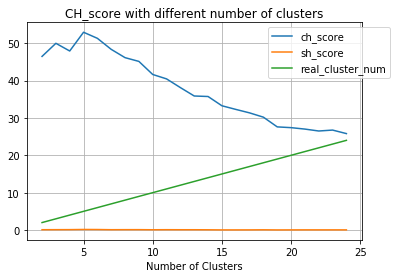

Optimal number for clusters: 5
Largest CH_score: 52.93224364630173
 
n_init= 10 gamma = 0.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


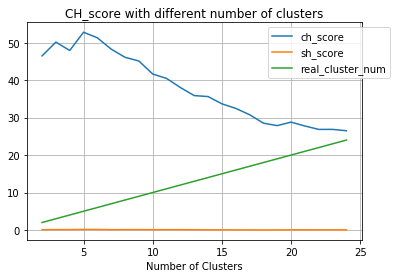

Optimal number for clusters: 5
Largest CH_score: 52.78305208941815
 
n_init= 10 gamma = 1.00 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


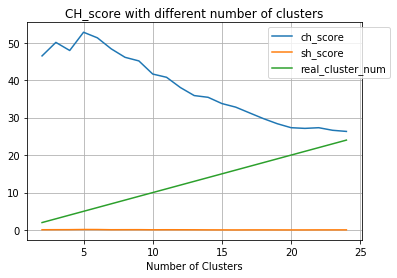

Optimal number for clusters: 5
Largest CH_score: 52.78305208941816
 
n_init= 10 gamma = 1.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


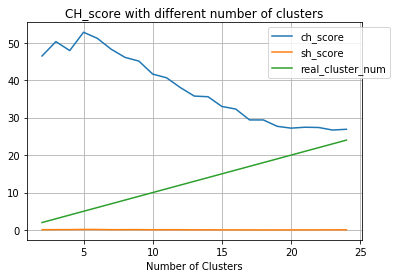

Optimal number for clusters: 5
Largest CH_score: 52.80746334060155
 
n_init= 15 gamma = 0.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


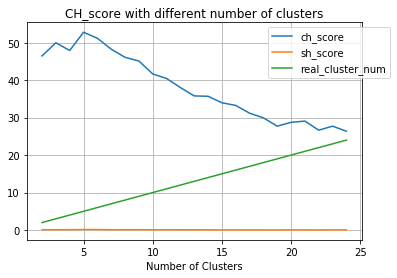

Optimal number for clusters: 5
Largest CH_score: 52.783052089418135
 
n_init= 15 gamma = 1.00 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


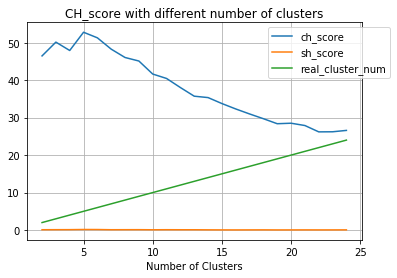

Optimal number for clusters: 5
Largest CH_score: 52.78305208941815
 
n_init= 15 gamma = 1.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


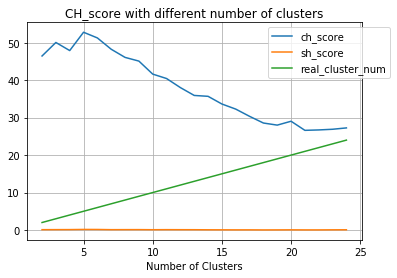

Optimal number for clusters: 5
Largest CH_score: 52.80746334060156
 
n_init= 20 gamma = 0.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


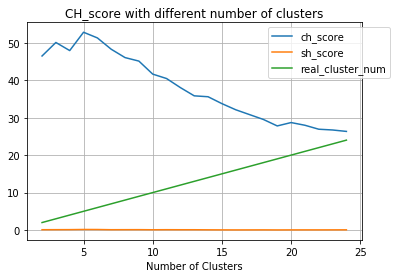

Optimal number for clusters: 5
Largest CH_score: 52.80746334060156
 
n_init= 20 gamma = 1.00 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


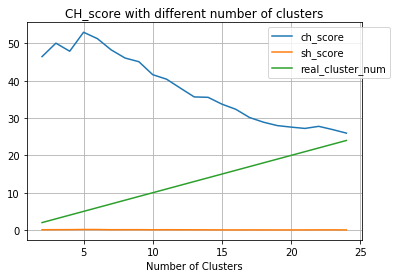

Optimal number for clusters: 5
Largest CH_score: 53.001358945307715
 
n_init= 20 gamma = 1.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


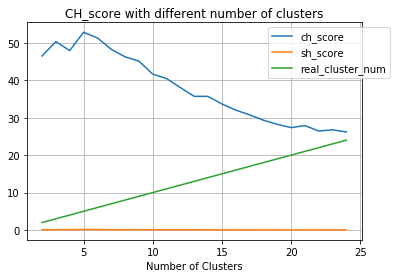

Optimal number for clusters: 5
Largest CH_score: 52.80746334060155
 
n_init= 25 gamma = 0.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


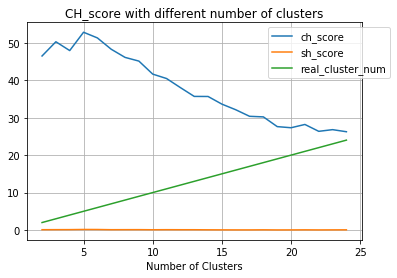

Optimal number for clusters: 5
Largest CH_score: 52.80746334060156
 
n_init= 25 gamma = 1.00 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


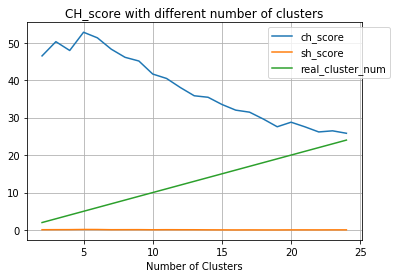

Optimal number for clusters: 5
Largest CH_score: 52.78305208941815
 
n_init= 25 gamma = 1.50 affinity =  nearest_neighbors n_neighbors =  25 :
above threshold


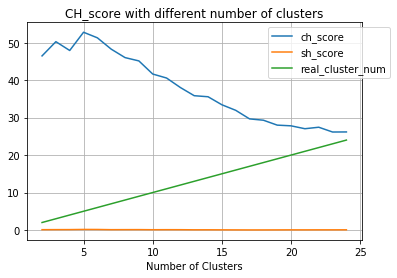

Optimal number for clusters: 5
Largest CH_score: 52.78305208941816
 


In [46]:
import warnings
warnings.filterwarnings('ignore')

SC_grid_search(m_pca,23,init_list,gamma_list,aff_list,neighbor_list,5,40)

# Dealing with outliers

In [47]:
#create dataframe for features after pca
pca_df = pd.DataFrame(m_pca)
pca_df.columns = [ "{}th component".format(i+1) for i in range(13)]
pca_df.index = train_df.index

#outliers out of range of(-3,3)
#after pca ,samples outliers:
pca_o = pca_df[(pca_df>3)|(pca_df<-3)].dropna(axis = 0)
#after pca,samples without outliers
pca_wo_o = pca_df[(pca_df<=3)&(pca_df>=-3)].dropna(axis = 0)

ward euclidean :
below threshold
 
ward l1 :
not applicable
 
ward l2 :
not applicable
 
ward manhattan :
not applicable
 
ward cosine :
not applicable
 
ward precomputed :
not applicable
 
complete euclidean :
above threshold


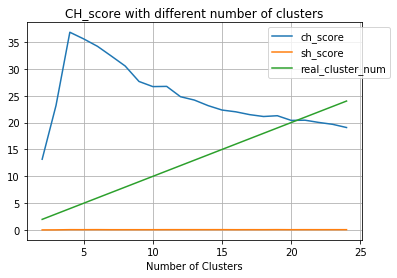

Optimal number for clusters: 4
Largest CH_score: 36.793578067837224
 
complete l1 :
below threshold
 
complete l2 :
above threshold


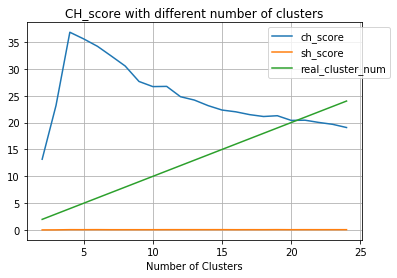

Optimal number for clusters: 4
Largest CH_score: 36.793578067837224
 
complete manhattan :
below threshold
 
complete cosine :
below threshold
 
complete precomputed :
not applicable
 
average euclidean :
below threshold
 
average l1 :
below threshold
 
average l2 :
below threshold
 
average manhattan :
below threshold
 
average cosine :
below threshold
 
average precomputed :
not applicable
 
single euclidean :
below threshold
 
single l1 :
below threshold
 
single l2 :
below threshold
 
single manhattan :
below threshold
 
single cosine :
below threshold
 
single precomputed :
not applicable
 


In [48]:
AC_grid_search(pca_wo_o,23,linkage_list,affinity_list,4,20)

n_init= 5 gamma = 1.00 affinity =  rbf n_neighbors =  25 :
above threshold


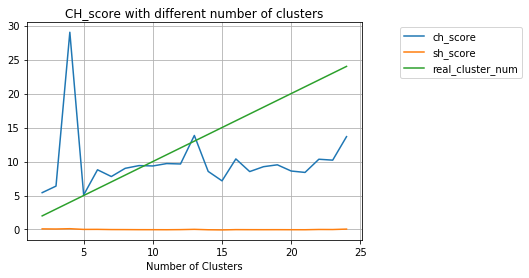

Optimal number for clusters: 4
Largest CH_score: 29.024067782639715
 


In [49]:
SC_grid_search(pca_wo_o,23,init_list,gamma_list,aff_list,neighbor_list,4,25)